In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

from sdebridge.setup import *
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import BrownianSDE
from sdebridge.utils import *
from sdebridge.data_processing import sample_ellipse
from sdebridge.plotting import plot_single_trajectory, plot_trajectories

## 2 Dimensional

### Learn the transition density of $X_t$

In [3]:
sde_config = ConfigDict()
sde_config.dim = 2
sde_config.N = 100
sde = BrownianSDE(sde_config)
bridge = DiffusionBridge(sde=sde)

KeyboardInterrupt: 

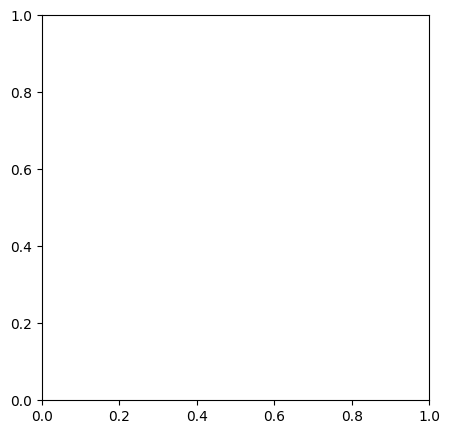

In [4]:
X0 = jnp.array([0.0, 0.0])
XT = jnp.array([2.0, 0.0])
forward_brownian_motion = bridge.simulate_forward_process(initial_val=X0, 
                                                          num_batches=32)
plot_trajectories(forward_brownian_motion["trajectories"], title="Forward Brownian Motion Trajectories")

In [ ]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act_fn": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 256,
                 "learning_rate": 2e-4}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:13<00:00,  7.15epoch/s, Epoch=100, loss=0.9749]


### Use learned transition score to simulate the backward bridge

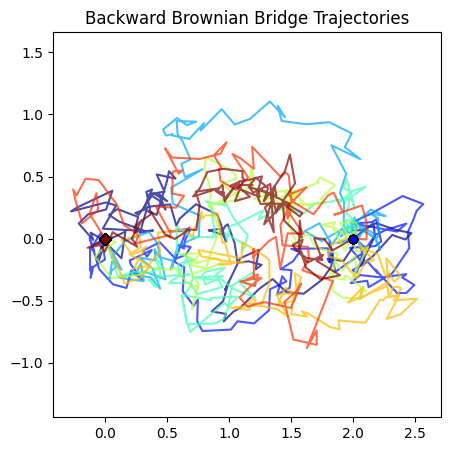

In [ ]:
score_p_true = lambda val, time: -(val - X0) / (time + 1e-4)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p_true,
                                                           num_batches=8)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

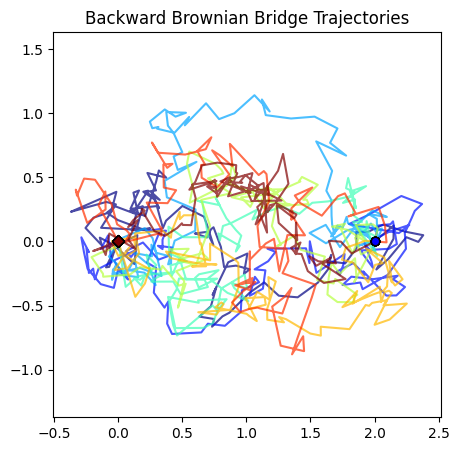

In [ ]:
score_p_est = partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p_est,
                                                           num_batches=8)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward Brownian Bridge Trajectories")

### Learn the transition density of the forward bridge from the simulated backward bridge

In [ ]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 64,
                "encoding_dim": 32,
                "act_fn": 'tanh',
                "encoder_layer_dims": [32, 32],
                "decoder_layer_dims": [32, 32],
                "batchnorm": True},
    "training": {"batch_size": 32,
                 "num_epochs": 100,
                 "num_batches_per_epoch": 128,
                 "learning_rate": 5e-4}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p_est,
                                               setup_params=setup_params)

Training: 100%|██████████| 100/100 [00:17<00:00,  5.66epoch/s, Epoch=100, loss=0.9250]


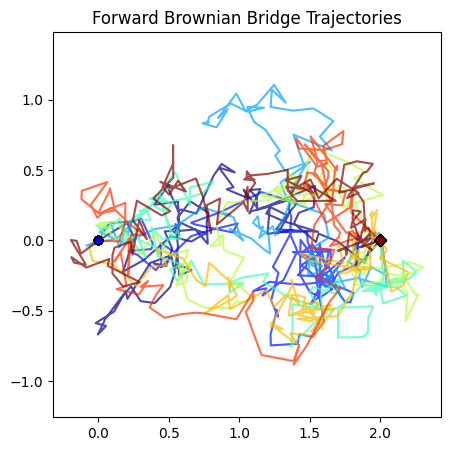

In [ ]:
# score_h = Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
score_h_true = lambda val, time: -(val - XT) / (sde.T - time + 1e-4)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h_true,
                                                         num_batches=8)
plot_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

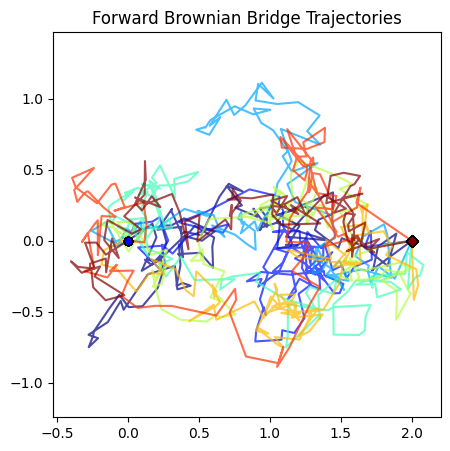

In [ ]:
score_h_est = partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
# score_h = lambda val, time: -(val - XT) / (sde.T - time + 1e-4)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0,
                                                         terminal_val=XT,
                                                         score_h=score_h_est,
                                                         num_batches=8)
plot_trajectories(forward_brownian_bridge["trajectories"], title="Forward Brownian Bridge Trajectories")

## Higher dimension

In [3]:
sde_config = ConfigDict()
sde_config.dim = 16
sde_config.N = 100

sde = BrownianSDE(sde_config)
bridge = DiffusionBridge(sde)

Text(0.5, 1.0, 'Circles')

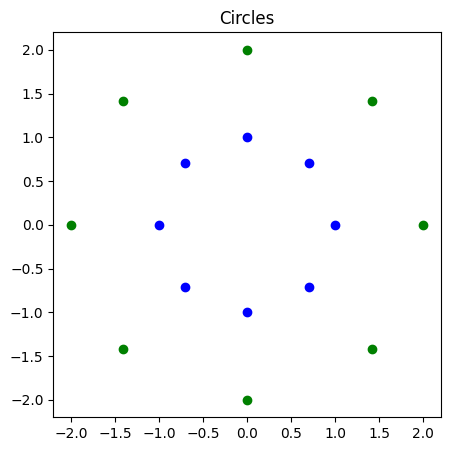

In [4]:
num_points = sde.dim // 2
X0 = sample_ellipse(num_points=num_points, scale=1.0)
XT = sample_ellipse(num_points=num_points, scale=2.0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X0.reshape(-1, 2)[:, 0], X0.reshape(-1, 2)[:, 1], color='b')
ax.scatter(XT.reshape(-1, 2)[:, 0], XT.reshape(-1, 2)[:, 1], color='g')
ax.set_title("Circles")

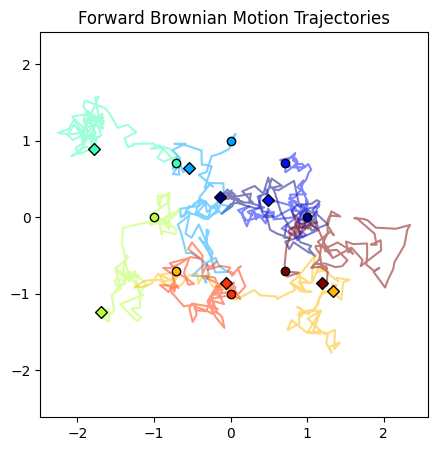

In [5]:
forward_brownian_motion = bridge.simulate_forward_process(initial_val=X0, 
                                                          num_batches=4)
for i in range(1):
    plot_single_trajectory(forward_brownian_motion["trajectories"][i], title="Forward Brownian Motion Trajectories")

In [6]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 64,
                "act_fn": 'tanh',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [128, 128],
                "batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 200,
                 "num_batches_per_epoch": 64,
                 "learning_rate": 1e-3}
}
score_p_state = bridge.learn_p_score(initial_val=X0, 
                                     setup_params=setup_params)

Training: 100%|██████████| 200/200 [04:43<00:00,  1.42s/epoch, Epoch=200, loss=7.5388]


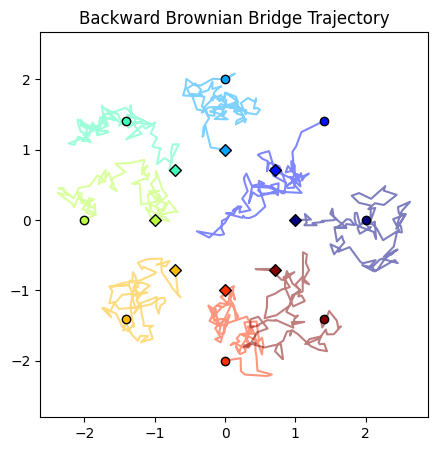

In [7]:
# score_p = Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
score_p_true = lambda val, time: -(val - X0) / (time + 1e-4)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p_true,
                                                           num_batches=16)
plot_single_trajectory(backward_brownian_bridge["trajectories"][2], title="Backward Brownian Bridge Trajectory")

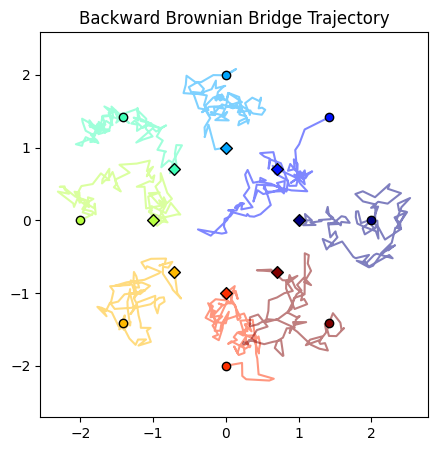

In [8]:
score_p_est = partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=X0, 
                                                           terminal_val=XT,
                                                           score_p=score_p_est,
                                                           num_batches=16)
plot_single_trajectory(backward_brownian_bridge["trajectories"][2], title="Backward Brownian Bridge Trajectory")

In [18]:
setup_params = {
    "network": {"output_dim": sde.dim,
                "time_embedding_dim": 32,
                "encoding_dim": 64,
                "act_fn": 'tanh',
                "encoder_layer_dims": [64, 64],
                "decoder_layer_dims": [128, 128],
                "batchnorm": True},
    "training": {"batch_size": 64,
                 "num_epochs": 200,
                 "num_batches_per_epoch": 64,
                 "learning_rate": 1e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=X0,
                                               terminal_val=XT,
                                               score_p=score_p_est,
                                               setup_params=setup_params)

Training: 100%|██████████| 200/200 [05:54<00:00,  1.77s/epoch, Epoch=200, loss=7.1617]


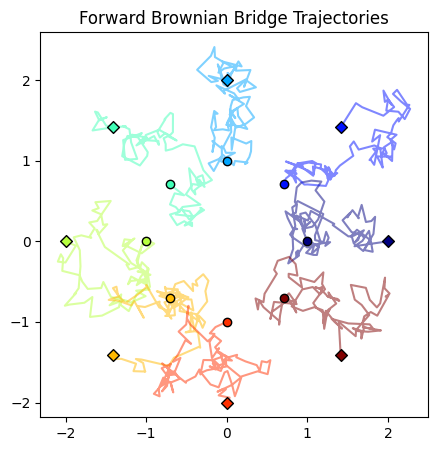

In [20]:
score_h_true = lambda val, time: -(val - XT) / (sde.T - time + 1e-4)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h_true,
                                                         num_batches=16)
plot_single_trajectory(forward_brownian_bridge["trajectories"][8], title="Forward Brownian Bridge Trajectories")

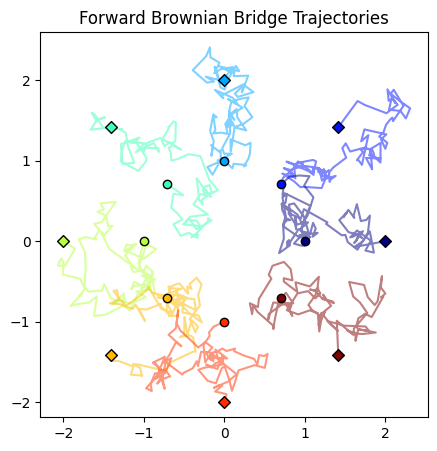

In [21]:
score_h_est = partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=X0, 
                                                         terminal_val=XT,
                                                         score_h=score_h_est,
                                                         num_batches=16)
plot_single_trajectory(forward_brownian_bridge["trajectories"][8], title="Forward Brownian Bridge Trajectories")